In [1]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib
%pip list

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "c:\Users\bdbag\anaconda3\envs\dev\lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "c:\Users\bdbag\anaconda3\envs\dev\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "c:\Users\bdbag\anaconda3\envs\dev\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "c:\Users\bdbag\anaconda3\envs\dev\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 126, in _parse_requirement_details
          marker = _parse_requirement_marker(
       

Package                       Version
----------------------------- ---------------
absl-py                       2.1.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
bcrypt                        3.2.0
beautiful

In [2]:
# Import Dependencies
import tensorflow as tf
import os
import cv2
import imghdr
import matplotlib.pyplot as plt

In [3]:
# Verifying correct data separation
os.listdir('chest_xray/train')
os.listdir('chest_xray/test')

['NORMAL', 'PNEUMONIA']

In [4]:
# Checking image size
img = cv2.imread(os.path.join('chest_xray', 'train', 'NORMAL', 'NORMAL-28501-0001.jpeg'))
img.shape

(2418, 2434, 3)

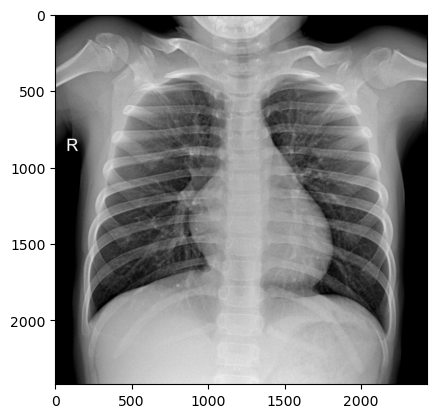

In [5]:
# Example image
plt.imshow(img)

In [6]:
# Dataset to train CNN
train_data = tf.keras.utils.image_dataset_from_directory('chest_xray/train', batch_size=32)
validation_data = tf.keras.utils.image_dataset_from_directory('chest_xray/train', batch_size=32, validation_split=0.3, subset="validation", seed=42)
test_data = tf.keras.utils.image_dataset_from_directory('chest_xray/test', batch_size=32)


Found 5232 files belonging to 2 classes.
Found 5232 files belonging to 2 classes.
Using 1569 files for validation.
Found 624 files belonging to 2 classes.


In [7]:
data_iterator = train_data.as_numpy_iterator()

In [8]:
# Getting a batch of data
batch = data_iterator.next()
batch[0].shape

(32, 256, 256, 3)

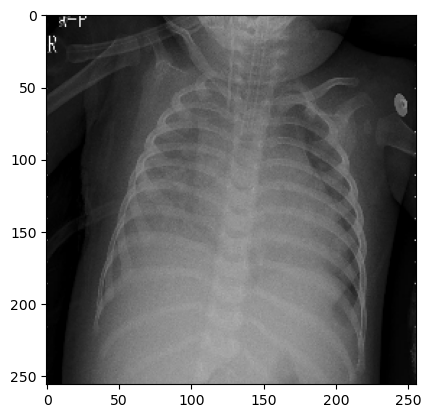

In [9]:
plt.imshow(batch[0][0].astype('int'))

In [10]:
# 1 = Pneumonia, 0 = Normal? (Will Double Check Later)
batch[1]

array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1])

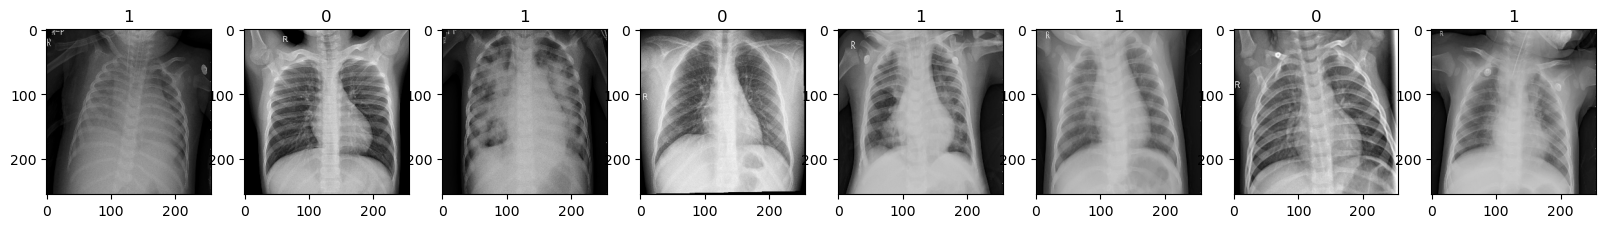

In [11]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype('int'))
    ax[idx].set_title(batch[1][idx])

In [12]:
batch[0].min(), batch[0].max()

(0.0, 255.0)

In [13]:
scaled = batch[0] / 255

In [14]:
scaled.min(), scaled.max()

(0.0, 1.0)

# PreProcessing

In [15]:
preprocess_data = train_data.map(lambda x, y: (x/255, y))

In [16]:
preprocess_data.as_numpy_iterator().next()[0].max()

1.0

In [17]:
len(preprocess_data)

164

### CNN Model Construction ###

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
# Convulational Layer #1
model.add(Conv2D(16, (3,3),1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
# Convulational Layer #2
model.add(Conv2D(32, (3,3),1, activation='relu'))
model.add(MaxPooling2D())
# Convulational Layer #3
model.add(Conv2D(16, (3,3),1, activation='relu'))
model.add(MaxPooling2D())
# Flatten Layer
model.add(Flatten())
# Dense Layer
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))




In [19]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        

In [20]:
# Model Training
first_regime = model.fit(train_data, epochs=10, validation_data=validation_data)

Epoch 1/10




164/164 [==============================] - 25s 148ms/step - loss: 7.9369 - accuracy: 0.8943 - val_loss: 0.0962 - val_accuracy: 0.9713
Epoch 2/10
164/164 [==============================] - 24s 145ms/step - loss: 0.1476 - accuracy: 0.9465 - val_loss: 0.0571 - val_accuracy: 0.9783
Epoch 3/10
164/164 [==============================] - 24s 145ms/step - loss: 0.0803 - accuracy: 0.9729 - val_loss: 0.0289 - val_accuracy: 0.9930
Epoch 4/10
164/164 [==============================] - 24s 146ms/step - loss: 0.0481 - accuracy: 0.9832 - val_loss: 0.0615 - val_accuracy: 0.9764
Epoch 5/10
164/164 [==============================] - 24s 145ms/step - loss: 0.0314 - accuracy: 0.9883 - val_loss: 0.0133 - val_accuracy: 0.9955
Epoch 6/10
164/164 [==============================] - 25s 150ms/step - loss: 0.0164 - accuracy: 0.9939 - val_loss: 0.0078 - val_accuracy: 0.9981
Epoch 7/10
164/164 [==============================] - 25s 152ms/step - loss: 0.0357 - accuracy: 0.9860 - val_loss: 0.0190 - val_accuracy: 0

In [21]:
first_regime.history

{'loss': [7.936919689178467,
  0.14762337505817413,
  0.08031432330608368,
  0.04813219979405403,
  0.031403426080942154,
  0.016410628333687782,
  0.03568917512893677,
  0.013854464516043663,
  0.06361193209886551,
  0.05342666059732437],
 'accuracy': [0.8943042755126953,
  0.9464831948280334,
  0.9728593230247498,
  0.9831804037094116,
  0.9883409738540649,
  0.9938837885856628,
  0.9860473871231079,
  0.9957951307296753,
  0.9787843823432922,
  0.9824159145355225],
 'val_loss': [0.09620780497789383,
  0.057132821530103683,
  0.028863273561000824,
  0.061507828533649445,
  0.013345914892852306,
  0.007806514855474234,
  0.018995482474565506,
  0.005885319784283638,
  0.1823405772447586,
  0.03192514181137085],
 'val_accuracy': [0.971319317817688,
  0.978330135345459,
  0.992989182472229,
  0.9764180779457092,
  0.9955385327339172,
  0.9980879426002502,
  0.992989182472229,
  0.9980879426002502,
  0.930528998374939,
  0.9872530102729797]}

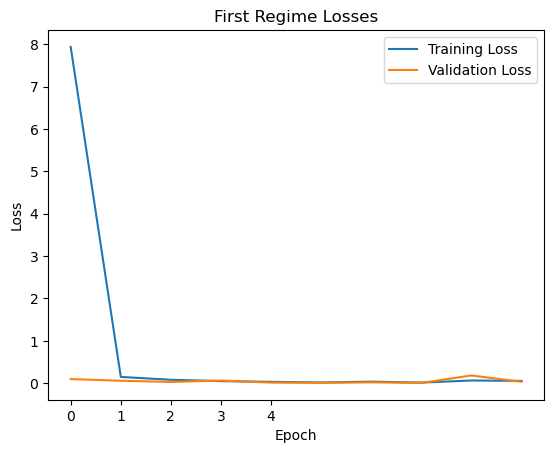

In [22]:
plt.plot(first_regime.history['loss'], label='Training Loss')
plt.plot(first_regime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0,5,1))
plt.title('First Regime Losses')
plt.legend()
plt.show()


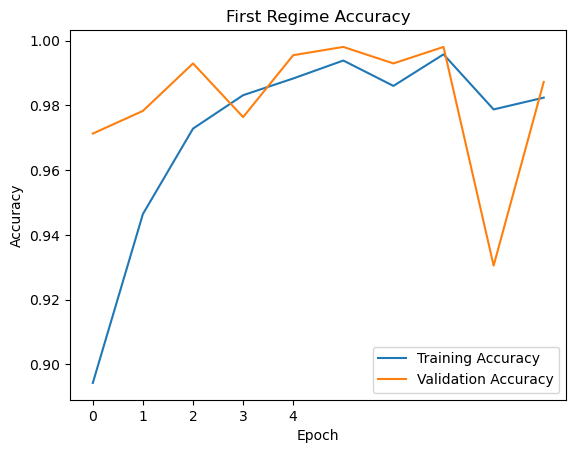

In [23]:
plt.plot(first_regime.history['accuracy'], label='Training Accuracy')
plt.plot(first_regime.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(0, 5))
plt.title('First Regime Accuracy')
plt.legend()
plt.show()
